C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Total segment read: 275
(3025, 14)


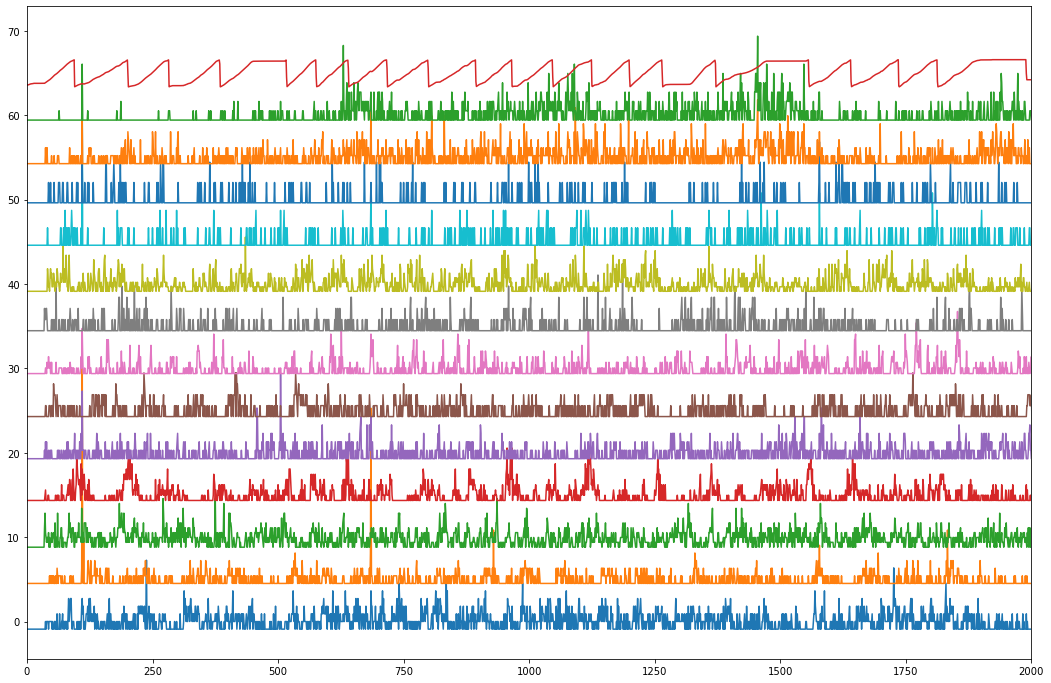

In [1]:
%run 01_load_data.ipynb

### Decode by regression

0.2836260613833522 0.2836501967418523 0.13299371281275485


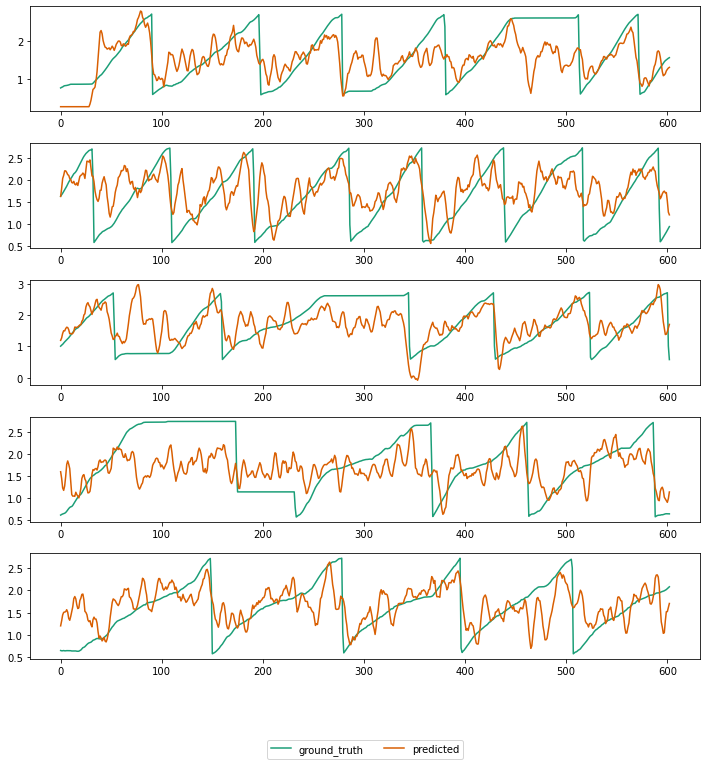

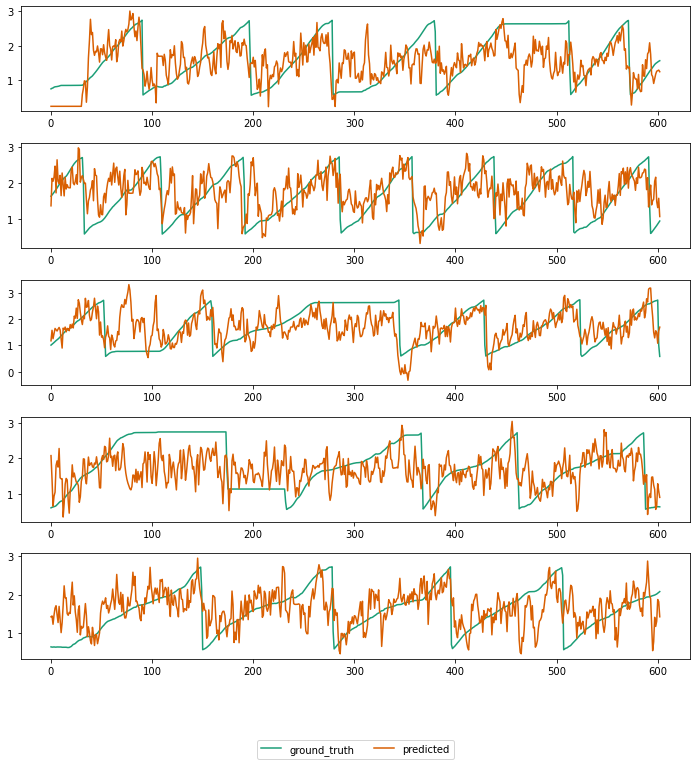

In [2]:
spk_train = agg_buffer[:,:-1]
pos = agg_buffer[:,-1]

scaler =preprocessing.StandardScaler()
norm_spk_train = scaler.fit_transform(spk_train)

#make sliding window
slidWin = 5
norm_spk_train = makeSlidingWinFeature(norm_spk_train,slidWin)
pos = pos[slidWin-1:]

polyFeatures = preprocessing.PolynomialFeatures(1).fit(norm_spk_train)
poly_spiketrain = polyFeatures.transform(norm_spk_train)
# poly_spiketrain= norm_spk_train

# regressor = linear_model.Lasso(alpha=0.1).fit(poly_spiketrain,pos)
regressor = svm.SVR(kernel='rbf',C=50,gamma='auto')
regressor.fit(poly_spiketrain,pos)

predicted = model_selection.cross_val_predict(regressor,poly_spiketrain,pos.ravel(),cv=5)
# predicted = model_selection.cross_val_predict(regressor,poly_spiketrain_ms4,norm_pos_online,cv=4)
predicted_smooth = signal.savgol_filter(predicted.ravel(),5,1)
r2 = metrics.r2_score(pos.squeeze(),predicted_smooth.ravel())
varExplain = metrics.explained_variance_score(pos.squeeze(),predicted_smooth.ravel())
varExplainRaw = metrics.explained_variance_score(pos.squeeze(),predicted.ravel())

print(r2,varExplain,varExplainRaw)
stripplot(pos,predicted_smooth,figsize=(12,12));
stripplot(pos,predicted,figsize=(12,12));


### Accuracy vs position

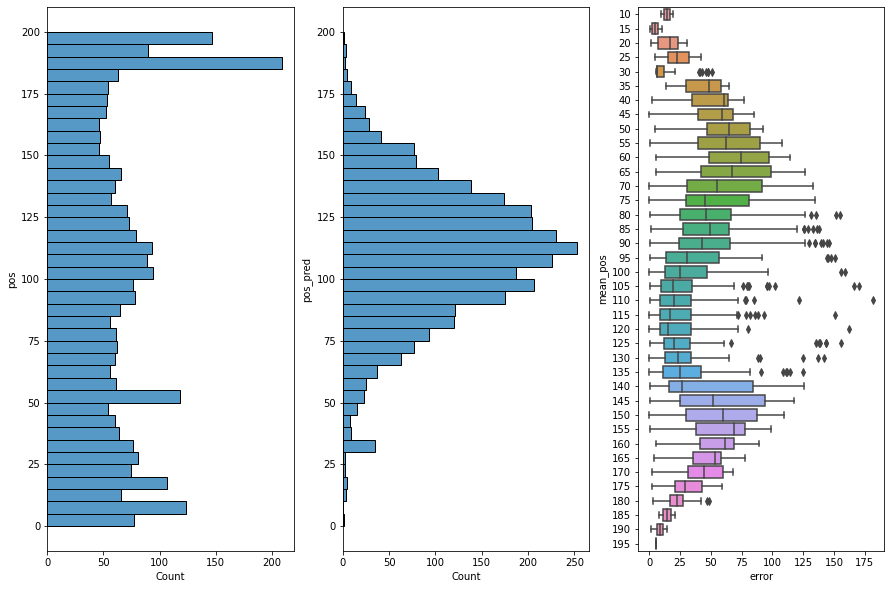

In [3]:
pos_scaled = preprocessing.minmax_scale(pos,(0,200))
predicted_scaled = preprocessing.minmax_scale(predicted,(0,200))
bins = np.arange(0,205,5)
pos_binned = np.digitize(pos_scaled,bins,right=True)
error = np.abs(pos_scaled-predicted_scaled)
df = pd.DataFrame({'pos_binned':bins[pos_binned],'error':error})

mean_pos = (predicted_scaled+pos_scaled)/2
df['mean_pos'] = bins[np.digitize(mean_pos,bins)]

df['pos_pred'] = predicted_scaled
df['pos'] = pos_scaled

fig,ax = plt.subplots(1,3,figsize=(15,10))
sns.histplot(y='pos',binwidth=5,data=df,ax=ax[0])
sns.histplot(y='pos_pred',binwidth=5,data=df,ax=ax[1])
sns.boxplot(y='mean_pos',x='error',orient='h',data=df,ax=ax[2]);
# sns.swarmplot(y='mean_pos',x='error',orient='h',data=df,ax=ax[1],color='.25')

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


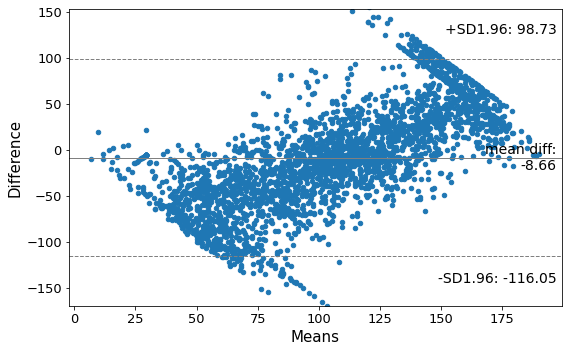

In [4]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(pos_scaled, predicted_scaled, ax = ax);

C:\Users\teristam\Anaconda3\envs\oeEnv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


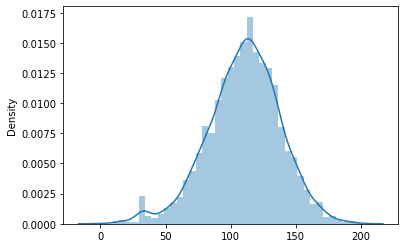

In [5]:
ax=sns.distplot(predicted_scaled)